# Variant Effect Prediction — Random Forest Demo (Tabular)

**Biological framing:** We often build a per-variant feature table (conservation, amino-acid change metrics, structural impact, etc.) and want to predict **pathogenic vs benign**.

This demo is intentionally synthetic to stay fast and reproducible.

### Pipeline
1. Biological features → tensor (`X`, `y`)
2. Model: `RandomForestClassifier`
3. Evaluation: accuracy + confusion matrix
4. Insight: feature importances (what the model uses)

Runtime target: **< 30 seconds**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

In [2]:
# 1. Synthetic biological feature table → tensor
# Features:
# - conservation_score: higher tends to be more pathogenic
# - aa_change_index: magnitude of amino-acid change
# - hydrophobicity_change: shift in hydrophobicity
# - structural_impact: higher tends to be more pathogenic

n = 1200
conservation_score = rng.uniform(0, 1, size=n)
aa_change_index = rng.normal(0, 1, size=n)
hydrophobicity_change = rng.normal(0, 1, size=n)
structural_impact = rng.uniform(0, 1, size=n)

# Nonlinear interaction: pathogenic when conservation is high AND structural impact is high.
# Plus some contribution from aa change magnitude.
logit = (
    4.0 * (conservation_score - 0.6)
    + 4.0 * (structural_impact - 0.6)
    + 2.0 * (conservation_score * structural_impact - 0.35)
    + 0.8 * np.abs(aa_change_index)
    - 0.3 * hydrophobicity_change
)

# Convert logit → probability and sample labels
p = 1 / (1 + np.exp(-logit))
y = (rng.uniform(0, 1, size=n) < p).astype(int)  # 1=pathogenic, 0=benign

X = np.column_stack([
    conservation_score,
    aa_change_index,
    hydrophobicity_change,
    structural_impact,
])

feature_names = [
    "conservation_score",
    "aa_change_index",
    "hydrophobicity_change",
    "structural_impact",
]

df = pd.DataFrame(X, columns=feature_names)
df["label_pathogenic"] = y

print(df.head())
print("Class balance (pathogenic rate):", y.mean().round(3))

   conservation_score  aa_change_index  hydrophobicity_change  \
0            0.773956        -0.985158               2.531905   
1            0.438878        -0.860842               1.480099   
2            0.858598         2.457424               1.119397   
3            0.697368         1.801742              -0.387788   
4            0.094177        -0.411749              -0.883200   

   structural_impact  label_pathogenic  
0           0.247068                 1  
1           0.859178                 0  
2           0.297330                 1  
3           0.210193                 0  
4           0.309250                 0  
Class balance (pathogenic rate): 0.429


In [3]:
# 2. Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (960, 4) Test: (240, 4)


In [4]:
# 3. Fit Random Forest

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=None,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.733


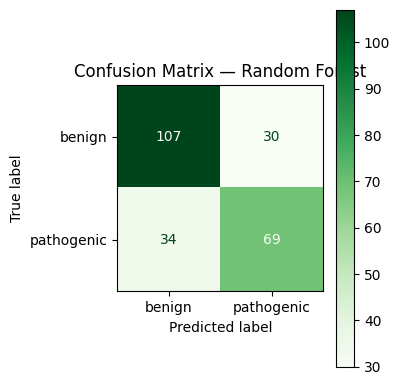

In [5]:
# 4. Evaluation: confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay(cm, display_labels=["benign", "pathogenic"]).plot(ax=ax, cmap="Greens")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

,feature,importance
0,conservation_score,0.381358
3,structural_impact,0.315934
1,aa_change_index,0.162100
2,hydrophobicity_change,0.140609


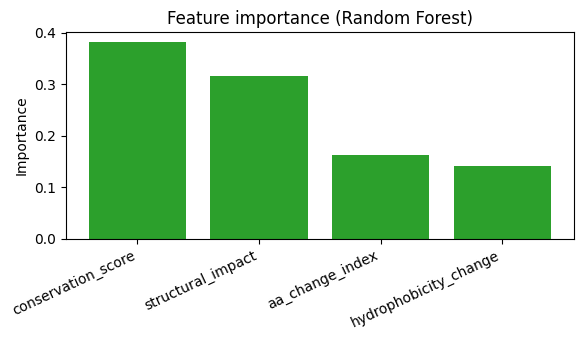

In [6]:
# 5. Insight: feature importances

importances = rf.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    "importance", ascending=False
)

display(imp_df)

plt.figure(figsize=(6, 3.5))
plt.bar(imp_df["feature"], imp_df["importance"], color="tab:green")
plt.ylabel("Importance")
plt.title("Feature importance (Random Forest)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()